**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions.

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [ ]:
#Install Objax
!pip --quiet install  objax
import objax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random
import matplotlib.pyplot as plt

##**Part 1. Building a CNN**

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [ ]:
#.load_data() by default returns a split between training and test set.
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170498071/170498071 [==============================] - 2s 0us/step



Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns.



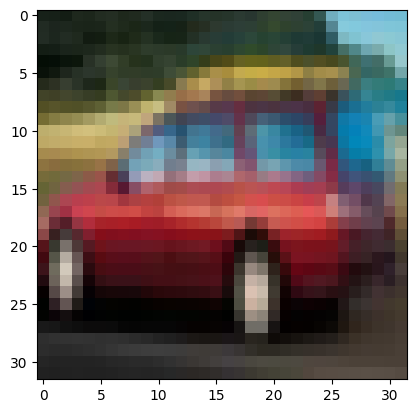

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output.

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[ 0.08896715 -0.07279256]
   [ 0.5039943  -0.5607323 ]
   [ 0.69289994 -0.86930597]]]]
Conv output: [[[[ 0.14117865  0.13613605  0.11829102 ...  1.0097966   0.9931872
     0.98468655]
   [ 0.19160458  0.16441517  0.16871695 ...  1.0254501   1.0205964
     1.0155538 ]
   [ 0.19664718  0.16639161  0.19392993 ...  1.0188706   1.0191027
     1.0148438 ]
   ...
   [ 0.22187413  0.21178894  0.21178894 ...  0.27654663  0.28158924
     0.29671702]
   [ 0.18657598  0.17649078  0.17649078 ...  0.3068022   0.30175963
     0.30175963]
   [ 0.1664056   0.161363    0.1664056  ...  0.37739852  0.37235594
     0.35722816]]

  [[-0.16435704 -0.15846358 -0.13737418 ... -1.1958665  -1.1757659
    -1.1652533 ]
   [-0.22329159 -0.19162536 -0.19630872 ... -1.2115611  -1.2058
    -1.1999066 ]
   [-0.22918504 -0.1938243  -0.225776   ... -1.2002045  -1.2009761
    -1.196932  ]
   ...
   [-0.259312   -0.24752508 -0.24752508 ... -0.31988704 -0.32578048
    -0.34346086]
   [-0.21805783 -0.20627

In [ ]:
print(np.shape(my_image))

(1, 3, 32, 32)


**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [ ]:
#Solution to the above problem

def my_conv_net(my_image, initial_filter_weights):
  my_conv_output = np.zeros([1, 2,32,32])
  for c in range(2):
    for h in range(32):
      for w in range(32):
        for t in range(3):
          my_conv_output[0,c,h,w] += my_image[0,t,h,w]*initial_filter_weights[0,0,t,c]
  return my_conv_output

In [ ]:
my_conv_output = my_conv_net(my_image,filter_weights)
print(my_conv_output)

[[[[ 0.14117865  0.13613605  0.11829101 ...  1.00979662  0.99318719
     0.98468649]
   [ 0.19160458  0.16441518  0.16871697 ...  1.02544999  1.0205965
     1.01555383]
   [ 0.19664718  0.16639161  0.19392993 ...  1.01887059  1.01910257
     1.01484382]
   ...
   [ 0.22187412  0.21178894  0.21178894 ...  0.27654666  0.28158924
     0.29671702]
   [ 0.18657598  0.17649078  0.17649078 ...  0.30680221  0.3017596
     0.3017596 ]
   [ 0.16640559  0.16136301  0.16640559 ...  0.37739855  0.37235594
     0.35722816]]

  [[-0.16435704 -0.15846358 -0.13737418 ... -1.19586647 -1.17576587
    -1.16525328]
   [-0.22329159 -0.19162536 -0.19630872 ... -1.21156096 -1.20580006
    -1.19990659]
   [-0.22918504 -0.19382431 -0.225776   ... -1.20020449 -1.20097613
    -1.19693196]
   ...
   [-0.25931197 -0.24752508 -0.24752508 ... -0.31988704 -0.32578048
    -0.34346083]
   [-0.21805783 -0.2062709  -0.2062709  ... -0.35524774 -0.34935433
    -0.34935433]
   [-0.194484   -0.18859056 -0.194484   ... -0.4377

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer.

In [ ]:
#Check that .mean((2,3)) rearranges your image
my_conv_mean = my_conv_output.mean((2,3))
my_conv_mean

array([[ 0.3549111 , -0.41205535]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.**



In [ ]:
#PUT YOUR CODE HERE
Linear_Layer = objax.nn.Linear(2,1)
ylinear = Linear_Layer(my_conv_mean)
print(ylinear)
model_w_value = Linear_Layer.w.value
model_b_value = Linear_Layer.b.value
print(model_w_value)
print(model_b_value)
ylinearmyself = model_w_value[0]*my_conv_mean[0][0]+model_w_value[1]*my_conv_mean[0][1]+model_b_value[0]
print(ylinearmyself)

[[-0.31539762]]
[[-0.08816949]
 [ 0.68948334]]
[0.]
[-0.31539762]


The training set is used to optimize the parameters such as weights and bias once the general structure of a neural network is determined to minize the difference between the prediction and actual results. While the validation set is used to assess the generalization performance of the model. In the assessment process, we can get to know whether the model perform well on data that was not seen before. Thus, we can make better decision on architecture and hyperparameter when optimizing the model.

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr*grad #My code here
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
# The base model is the same model used in part(2)
def train(EPOCHS = 80, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it : it+BATCH] #My code here
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]    #My code here
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.32 Validation Loss 2.31 Training Accuracy 10.30 Validation Accuracy 10.43
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.38 Validation Accuracy 11.20
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.25 Validation Accuracy 11.63
Epoch 0004  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.16 Validation Accuracy 12.93
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 12.65 Validation Accuracy 13.72
Epoch 0006  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 13.60 Validation Accuracy 12.28
Epoch 0007  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 12.65 Validation Accuracy 13.07
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 13.05 Validation Accuracy 13.72
Epoch 0009  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 13.53 Validation Accuracy 13.87
Epoch 0010  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 13.62 Valida

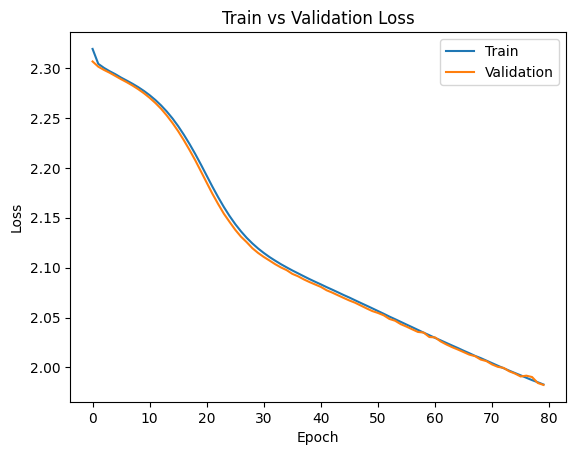

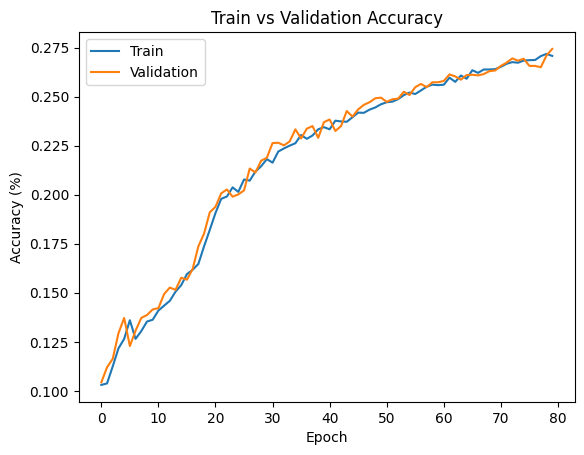

In [ ]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

In [ ]:
def test():
  test_prediction = predict(X_test).argmax(1)
  test_accuracy = (np.array(test_prediction).flatten() == Y_test).sum()/X_test.shape[0]
  print(test_accuracy*100)

test()

26.833333333333332


# **P2 Question 4**
A hyper parameter is a parameter for a machine learning model that is set before training and influences the model's learning process and is not learned from the training data.
Using the test set to evaluation can lead the model to overfitting the specific test set, affects the generalization performance of the model. The test accuracy should reflect the performance of the model with unseen data. If we tune hyperparamter and evaluate the performance using the same "test" set. We may overfit the model to the "test" set. That is also why we have a validation set.

# **P2 Question 5**
My set of hyperparameters are {batch size,learning rate, number of ouputs of conv layer 1, number of conv layers}
H1 = {64,0.001, 16,2}
H2 = {16,0.01,32,3}

In [ ]:
class ConvNet_H1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#You can examine the architecture of our CNN by calling model.vars()
H1_model = ConvNet_H1()

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = H1_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predictH1 = objax.Jit(lambda x: objax.functional.softmax(H1_model(x)), H1_model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, H1_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in H1_model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr * grad
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train_h1(EPOCHS = 80, BATCH = 64, LEARNING_RATE = 0.001):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it + BATCH]  # Slice the batch from shuffled indices
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predictH1(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it + BATCH]  # Slice the batch from shuffled indices
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predictH1(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.32 Validation Loss 2.30 Training Accuracy 12.17 Validation Accuracy 15.23
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 15.45 Validation Accuracy 14.28
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 14.19 Validation Accuracy 13.80
Epoch 0004  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 13.72 Validation Accuracy 14.18
Epoch 0005  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 13.54 Validation Accuracy 14.33
Epoch 0006  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 13.71 Validation Accuracy 14.22
Epoch 0007  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 13.77 Validation Accuracy 13.88
Epoch 0008  Training Loss 2.27 Validation Loss 2.26 Training Accuracy 13.63 Validation Accuracy 13.83
Epoch 0009  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 13.53 Validation Accuracy 13.95
Epoch 0010  Training Loss 2.26 Validation Loss 2.25 Training Accuracy 14.30 Valida

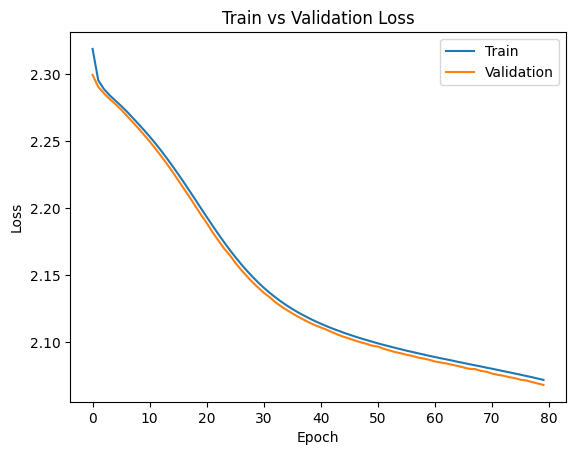

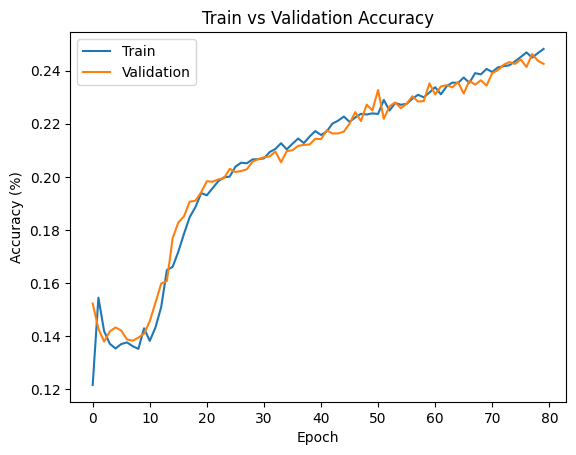

In [ ]:
train_h1()

In [ ]:
def testh1():
  test_prediction = predictH1(X_test).argmax(1)
  test_accuracy = (np.array(test_prediction).flatten() == Y_test).sum()/X_test.shape[0]
  print(test_accuracy*100)

testh1()

23.400000000000002


In [ ]:
class ConvNet_H2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_3(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#You can examine the architecture of our CNN by calling model.vars()
H2_model = ConvNet_H2()

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = H2_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predictH2 = objax.Jit(lambda x: objax.functional.softmax(H2_model(x)), H2_model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, H2_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in H2_model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr * grad
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def trainh2(EPOCHS = 80, BATCH = 16, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it + BATCH]  # Slice the batch from shuffled indices
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predictH2(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it + BATCH]  # Slice the batch from shuffled indices
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predictH2(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.19 Validation Loss 2.06 Training Accuracy 19.85 Validation Accuracy 22.82
Epoch 0002  Training Loss 2.00 Validation Loss 1.95 Training Accuracy 28.85 Validation Accuracy 26.58
Epoch 0003  Training Loss 1.89 Validation Loss 1.89 Training Accuracy 34.54 Validation Accuracy 28.37
Epoch 0004  Training Loss 1.82 Validation Loss 1.79 Training Accuracy 37.92 Validation Accuracy 35.10
Epoch 0005  Training Loss 1.74 Validation Loss 1.72 Training Accuracy 41.44 Validation Accuracy 35.25
Epoch 0006  Training Loss 1.68 Validation Loss 1.71 Training Accuracy 43.71 Validation Accuracy 38.10
Epoch 0007  Training Loss 1.64 Validation Loss 1.59 Training Accuracy 45.99 Validation Accuracy 41.85
Epoch 0008  Training Loss 1.59 Validation Loss 1.56 Training Accuracy 47.74 Validation Accuracy 43.47
Epoch 0009  Training Loss 1.56 Validation Loss 1.56 Training Accuracy 49.27 Validation Accuracy 42.95
Epoch 0010  Training Loss 1.53 Validation Loss 1.53 Training Accuracy 50.51 Valida

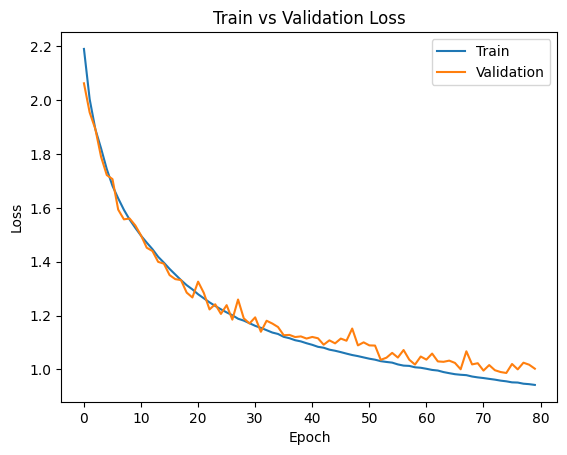

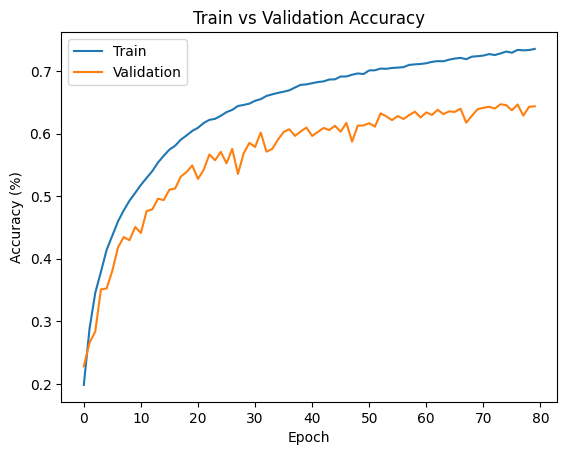

In [ ]:
trainh2()

In [ ]:
def testh2():
  test_prediction = predictH2(X_test).argmax(1)
  test_accuracy = (np.array(test_prediction).flatten() == Y_test).sum()/X_test.shape[0]
  print(test_accuracy*100)

testh2()

63.93333333333333


Base Model: 27.43% at Epoch 80 <br>
M1: 24.62% at Epoch 78 <br>
M2: 64.67% at Epoch 74 <br>
Pick M2 as final model because it has the highest validation accuracy. We pick the model with the highest validation accuracy because the validation accuracy serves as a proxy for the model's generalization performance on new, unseen data. The validation set is a separate dataset not used during training, and it allows for an unbiased evaluation of how well the model is likely to perform on examples it has not encountered before. Test accuracy is 63.933333

You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

Choose CIFAR100


In [ ]:
#.load_data() by default returns a split between training and test set.
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar100.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

In [ ]:
#Base model used initially
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr*grad #My code here
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
# The base model is the same model used in part(2)
def train(EPOCHS = 80, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it : it+BATCH] #My code here
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]    #My code here
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.98 Validation Accuracy 0.97
Epoch 0002  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 1.00 Validation Accuracy 0.97
Epoch 0003  Training Loss 4.61 Validation Loss 4.61 Training Accuracy 0.99 Validation Accuracy 0.97
Epoch 0004  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 1.00 Validation Accuracy 0.97
Epoch 0005  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 0.99 Validation Accuracy 0.93
Epoch 0006  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 0.98 Validation Accuracy 0.90
Epoch 0007  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 0.98 Validation Accuracy 0.83
Epoch 0008  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 0.95 Validation Accuracy 0.85
Epoch 0009  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 0.94 Validation Accuracy 0.83
Epoch 0010  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 0.94 Validation Accuracy 0.82


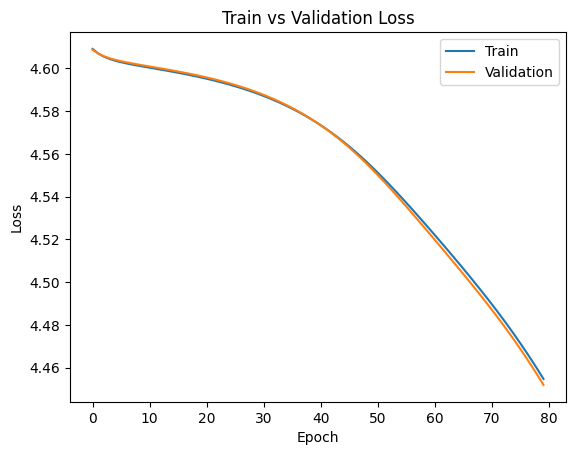

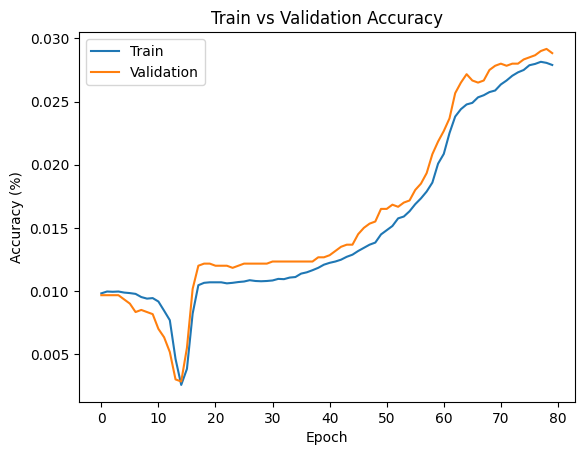

In [ ]:
train()

# **P3 Q3**
The hyperparameters I would like to tune here is batch size, learning rate,number of convolution layers, and number of outputs of the first convolution layer. After trying out different combinations of these hyperparameters.
I found a better model with batch size = 16, number of convolution layer =3, number of outputs of the first convolution layer =24, learning rate = 0.01

In [ ]:
class ConvNet_P3(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 24, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(24, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_3(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#You can examine the architecture of our CNN by calling model.vars()
P3_model = ConvNet_P3()

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = P3_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predictP3 = objax.Jit(lambda x: objax.functional.softmax(P3_model(x)), P3_model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, P3_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in P3_model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr * grad
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def trainP3(EPOCHS = 80, BATCH = 16, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it + BATCH]  # Slice the batch from shuffled indices
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predictP3(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it + BATCH]  # Slice the batch from shuffled indices
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predictP3(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 4.60 Validation Loss 4.60 Training Accuracy 1.06 Validation Accuracy 0.98
Epoch 0002  Training Loss 4.58 Validation Loss 4.55 Training Accuracy 1.18 Validation Accuracy 1.77
Epoch 0003  Training Loss 4.48 Validation Loss 4.40 Training Accuracy 2.74 Validation Accuracy 2.55
Epoch 0004  Training Loss 4.34 Validation Loss 4.28 Training Accuracy 5.06 Validation Accuracy 4.75
Epoch 0005  Training Loss 4.24 Validation Loss 4.18 Training Accuracy 7.06 Validation Accuracy 6.37
Epoch 0006  Training Loss 4.16 Validation Loss 4.14 Training Accuracy 8.61 Validation Accuracy 5.88
Epoch 0007  Training Loss 4.09 Validation Loss 4.05 Training Accuracy 10.16 Validation Accuracy 8.13
Epoch 0008  Training Loss 4.02 Validation Loss 3.98 Training Accuracy 11.59 Validation Accuracy 8.90
Epoch 0009  Training Loss 3.95 Validation Loss 3.92 Training Accuracy 13.18 Validation Accuracy 9.87
Epoch 0010  Training Loss 3.88 Validation Loss 3.83 Training Accuracy 14.57 Validation Accuracy 1

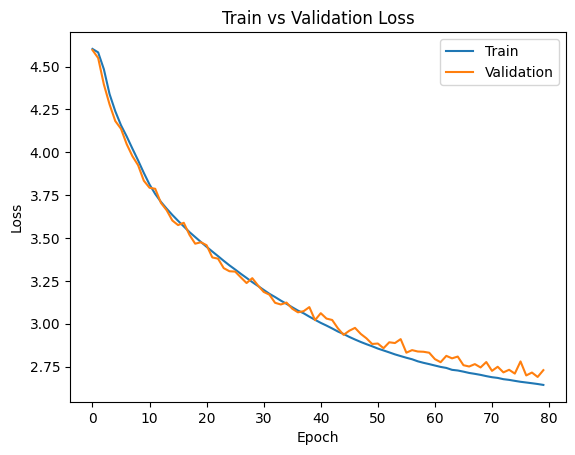

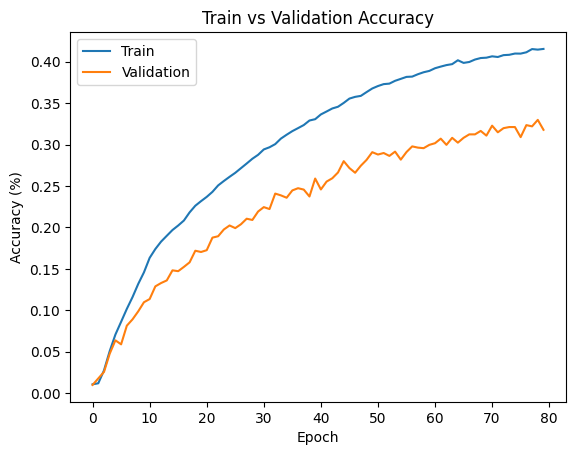

In [ ]:
trainP3()

In [ ]:
def testp3():
  test_prediction = predictP3(X_test).argmax(1)
  test_accuracy = (np.array(test_prediction).flatten() == Y_test).sum()/X_test.shape[0]
  print(test_accuracy*100)

testp3()

30.916666666666664


The highest validation accuracy appears at Epoch 79. It is 32.98%.
Final model has changed batch size from 32 to 16, number of convolution layer from 2 to 3, number of outputs of the first convolution layer from 16 to 24, learning rate from 9*10^-4 to 0.01. Test accuracy = 30.9167%

##**Problem 4. Open-Ended Exploration**

**Additional hyperparameter tuning**
The hyperparamter I would like to explore is k, the size of the convolution kernel (the size of the filter)
Choose the final model in part3 as the base model.
Let k1 be the size of the convolution filter, k2 be the size of the convolution filter, k3 be the size of the convolution filter. Try different combinations of (k1,k2,k3)<br>
Try(2,2,5) first


In [ ]:
class ConvNet_P4A(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 24, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(24, 32, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 5), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_3(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#You can examine the architecture of our CNN by calling model.vars()
P4A_model = ConvNet_P4A()

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = P4A_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predictP4A = objax.Jit(lambda x: objax.functional.softmax(P4A_model(x)), P4A_model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, P4A_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in P4A_model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr * grad
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def trainP4A(EPOCHS = 80, BATCH = 16, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it + BATCH]  # Slice the batch from shuffled indices
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predictP4A(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it + BATCH]  # Slice the batch from shuffled indices
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predictP4A(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 4.60 Validation Loss 4.58 Training Accuracy 1.32 Validation Accuracy 1.73
Epoch 0002  Training Loss 4.50 Validation Loss 4.36 Training Accuracy 3.27 Validation Accuracy 3.47
Epoch 0003  Training Loss 4.26 Validation Loss 4.21 Training Accuracy 6.83 Validation Accuracy 5.12
Epoch 0004  Training Loss 4.14 Validation Loss 4.09 Training Accuracy 9.14 Validation Accuracy 7.15
Epoch 0005  Training Loss 4.03 Validation Loss 3.99 Training Accuracy 11.58 Validation Accuracy 8.25
Epoch 0006  Training Loss 3.94 Validation Loss 3.90 Training Accuracy 13.33 Validation Accuracy 9.65
Epoch 0007  Training Loss 3.85 Validation Loss 3.79 Training Accuracy 15.26 Validation Accuracy 11.43
Epoch 0008  Training Loss 3.76 Validation Loss 3.71 Training Accuracy 17.30 Validation Accuracy 13.07
Epoch 0009  Training Loss 3.68 Validation Loss 3.63 Training Accuracy 19.04 Validation Accuracy 14.45
Epoch 0010  Training Loss 3.60 Validation Loss 3.54 Training Accuracy 20.59 Validation Accur

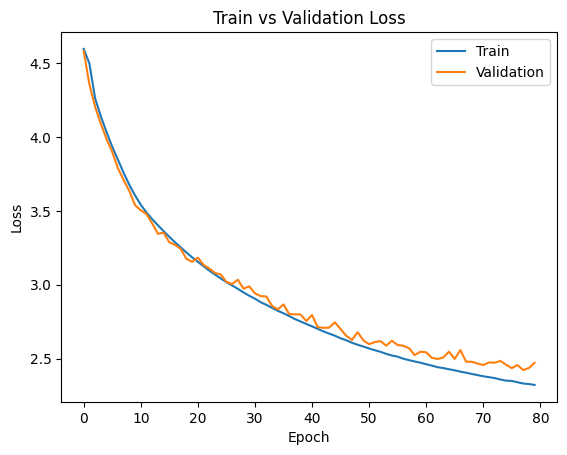

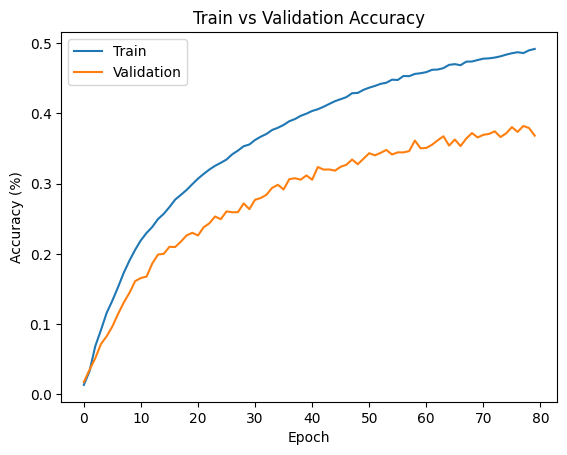

In [ ]:
trainP4A()

In [ ]:
def testp4a():
  test_prediction = predictP4A(X_test).argmax(1)
  test_accuracy = (np.array(test_prediction).flatten() == Y_test).sum()/X_test.shape[0]
  print(test_accuracy*100)

testp4a()

34.75


Try(2,3,5)

In [ ]:
class ConvNet_P4B(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 24, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(24, 32, 3), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 5), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_3(x)

    x = x.mean((2,3)) #<--- global average pooling
    x = self.linear(x)
    return x

#You can examine the architecture of our CNN by calling model.vars()
P4B_model = ConvNet_P4B()

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = P4B_model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predictP4B = objax.Jit(lambda x: objax.functional.softmax(P4B_model(x)), P4B_model.vars())

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, P4B_model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in P4B_model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      params.value -= lr * grad
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def trainP4B(EPOCHS = 80, BATCH = 16, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it + BATCH]  # Slice the batch from shuffled indices
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predictP4B(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it + BATCH]  # Slice the batch from shuffled indices
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predictP4B(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 4.59 Validation Loss 4.54 Training Accuracy 1.72 Validation Accuracy 2.30
Epoch 0002  Training Loss 4.42 Validation Loss 4.32 Training Accuracy 3.51 Validation Accuracy 3.07
Epoch 0003  Training Loss 4.28 Validation Loss 4.22 Training Accuracy 7.08 Validation Accuracy 4.92
Epoch 0004  Training Loss 4.12 Validation Loss 4.03 Training Accuracy 10.45 Validation Accuracy 7.65
Epoch 0005  Training Loss 3.99 Validation Loss 3.96 Training Accuracy 12.63 Validation Accuracy 9.35
Epoch 0006  Training Loss 3.89 Validation Loss 3.83 Training Accuracy 14.66 Validation Accuracy 11.48
Epoch 0007  Training Loss 3.79 Validation Loss 3.74 Training Accuracy 16.98 Validation Accuracy 13.38
Epoch 0008  Training Loss 3.70 Validation Loss 3.64 Training Accuracy 19.20 Validation Accuracy 14.12
Epoch 0009  Training Loss 3.61 Validation Loss 3.62 Training Accuracy 21.10 Validation Accuracy 14.72
Epoch 0010  Training Loss 3.54 Validation Loss 3.50 Training Accuracy 22.90 Validation Acc

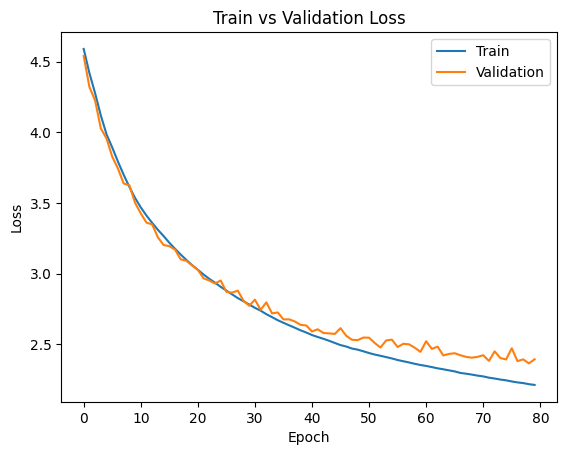

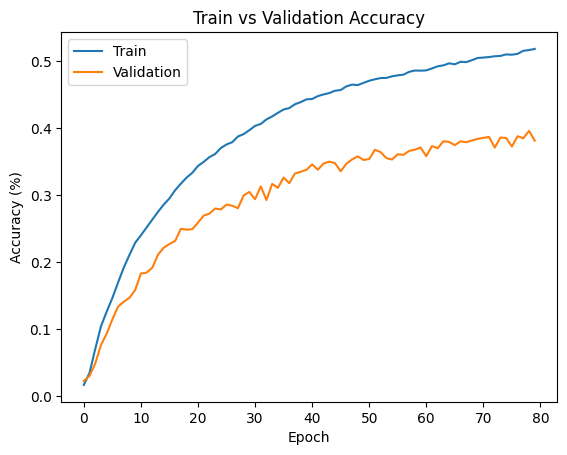

In [ ]:
trainP4B()

In [ ]:
def testp4b():
  test_prediction = predictP4B(X_test).argmax(1)
  test_accuracy = (np.array(test_prediction).flatten() == Y_test).sum()/X_test.shape[0]
  print(test_accuracy*100)

testp4b()

36.53333333333333


The (2,2,5) model has best validation accuracy 38.22% at epoch 78. Its test accuracy is 34.75%.<br>
The (2,3,5) model has best validation accuracy 39.57% at epoch 79. Its test accuracy is 36.533%.
Pick the (2,3,5) model as it has highest validation accuracy.<br>
Small fitler capture local features and details of the graph. While larger filters have a broader receptive field and can capture more global features.
Following the logic of using smaller filters to capture details in the earlier layer and using larger filters to capture the whole picture later, I designed these two combinations.As supported by the results, tuning the size of filters are a feasible approach to increase performance.
